Import neccessary libraries 

In [ ]:
pip install -r requirements.txt

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit



import warnings
warnings.filterwarnings('ignore')

--------------
Data taken from 1999-2019 (20 Year Period)

2020 will only be presented once testing is finalized.

In [3]:
#Downloading of data from Yahoo Finance which will be used for model training
end = '2019-12-31'
start = '1999-01-02'

trainingData = yf.download('^GSPC', start=start, end=end)
trainingData.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1999-01-04,1229.229980,1248.810059,1219.099976,1228.099976,1228.099976,877000000
1999-01-05,1228.099976,1246.109985,1228.099976,1244.780029,1244.780029,775000000
1999-01-06,1244.780029,1272.500000,1244.780029,1272.339966,1272.339966,986900000
1999-01-07,1272.339966,1272.339966,1257.680054,1269.729980,1269.729980,863000000
1999-01-08,1269.729980,1278.239990,1261.819946,1275.089966,1275.089966,937800000


In [4]:
#Downloading of data from Yahoo Finance which will be used for model testing
end = '2024-03-25'
start = '2020-01-02'

testingData = yf.download('^GSPC', start=start, end=end)
testingData.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,3244.669922,3258.139893,3235.530029,3257.850098,3257.850098,3459930000
2020-01-03,3226.360107,3246.149902,3222.340088,3234.850098,3234.850098,3484700000
2020-01-06,3217.550049,3246.840088,3214.639893,3246.280029,3246.280029,3702460000
2020-01-07,3241.860107,3244.909912,3232.429932,3237.179932,3237.179932,3435910000
2020-01-08,3238.590088,3267.070068,3236.669922,3253.050049,3253.050049,3726840000


In [5]:
#Prediction will take place on Adj Close price, therefore we must isolate Adj Close.
trainprice = trainingData['Adj Close']
trainData = trainprice.values

testprice = testingData['Adj Close']
testData = testprice.values

In [6]:
trainData


array([1228.09997559, 1244.7800293 , 1272.33996582, ..., 3239.90991211,
       3240.02001953, 3221.29003906])

Plotting of High vs Low

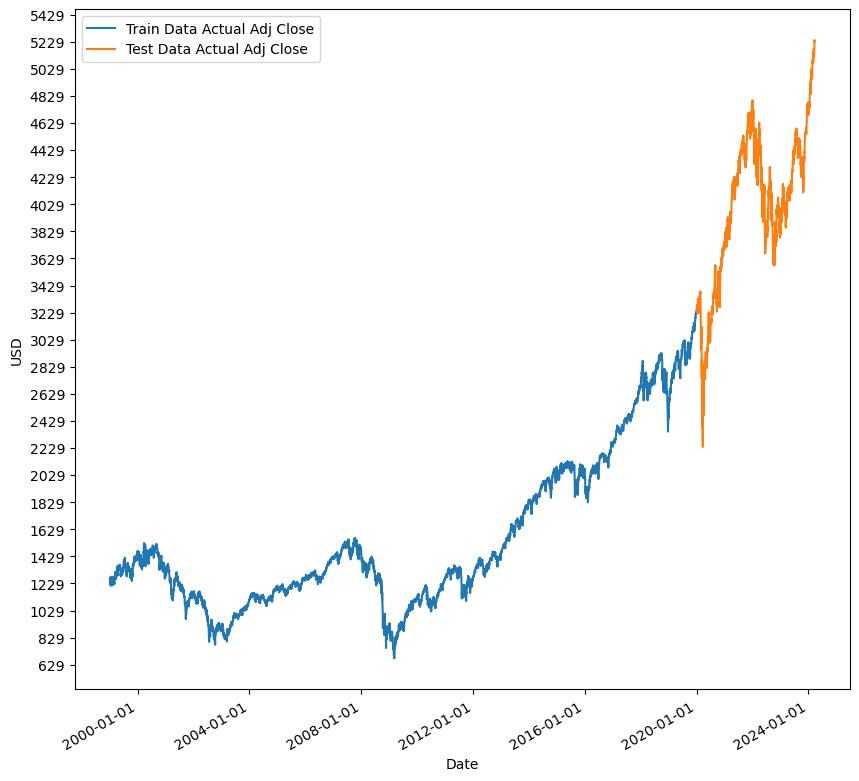

In [7]:
plt.figure(figsize=(10,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().yaxis.set_major_locator(mdates.DayLocator(interval=200))

plt.plot(trainingData.index, trainingData['Adj Close'], label='Train Data Actual Adj Close')
plt.plot(testingData.index, testingData['Adj Close'], label='Test Data Actual Adj Close')
plt.xlabel('Date')
plt.ylabel('USD')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

In [8]:
sc = MinMaxScaler(feature_range=(0,1))
trainDataScaled = sc.fit_transform(trainData.reshape(-1, 1))
testDataScaled = sc.fit_transform(testData.reshape(-1, 1))

In [9]:
n_steps = 20

xTrain, yTrain = [], []

for i in range(n_steps, len(trainDataScaled)):
    xTrain.append(trainDataScaled[i-n_steps:i, 0])
    yTrain.append(trainDataScaled[i, 0])
      
xTrain, yTrain = np.array(xTrain), np.array(yTrain)
xTrain = np.reshape(xTrain, (xTrain.shape[0], xTrain.shape[1], 1))


In [10]:
#LSTM Model

model = Sequential()

#Layer 1
model.add(LSTM(units=200,return_sequences=True,input_shape=(xTrain.shape[1], 1)))
model.add(Dropout(0.2))
#Layer 2
model.add(LSTM(units=200,return_sequences=True))
model.add(Dropout(0.2))
#Layer 3
model.add(LSTM(units=200,return_sequences=True))
model.add(Dropout(0.2))
#Layer 4
model.add(LSTM(units=200, return_sequences=False))
model.add(Dropout(0.2))
#Layer 5
model.add(Dense(units=1))
model.compile(optimizer='adam',loss='mean_squared_error', metrics=[RootMeanSquaredError(), MeanAbsoluteError()])
model.summary()

#Early stopping parameters to stop unnecessary training
earlyStopping = EarlyStopping(
    monitor='val_root_mean_squared_error',
    patience=15,
    mode='min',
    min_delta = 0.000001
)


2024-03-26 14:45:51.133252: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 200)           161600    
                                                                 
 dropout (Dropout)           (None, 20, 200)           0         
                                                                 
 lstm_1 (LSTM)               (None, 20, 200)           320800    
                                                                 
 dropout_1 (Dropout)         (None, 20, 200)           0         
                                                                 
 lstm_2 (LSTM)               (None, 20, 200)           320800    
                                                                 
 dropout_2 (Dropout)         (None, 20, 200)           0         
                                                                 
 lstm_3 (LSTM)               (None, 200)               3

In [11]:
#Method to plot the training metric vs validation metric
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

In [12]:
#Evaluation of model to confirm if parameters set above are valid
eval = model.evaluate(xTrain, yTrain)

165/165 [==============================] - 8s 41ms/step - loss: 0.1702 - root_mean_squared_error: 0.4126 - mean_absolute_error: 0.3464


In [13]:
len(xTrain)

5262

Epoch 1/100
31/31 [==============================] - 19s 438ms/step - loss: 0.0079 - root_mean_squared_error: 0.0891 - mean_absolute_error: 0.0674 - val_loss: 0.0164 - val_root_mean_squared_error: 0.1279 - val_mean_absolute_error: 0.1015
Epoch 2/100
31/31 [==============================] - 17s 537ms/step - loss: 0.0119 - root_mean_squared_error: 0.1090 - mean_absolute_error: 0.0874 - val_loss: 0.0343 - val_root_mean_squared_error: 0.1851 - val_mean_absolute_error: 0.1651
Epoch 3/100
31/31 [==============================] - 17s 539ms/step - loss: 0.0089 - root_mean_squared_error: 0.0946 - mean_absolute_error: 0.0810 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0753 - val_mean_absolute_error: 0.0608
Epoch 4/100
31/31 [==============================] - 19s 627ms/step - loss: 0.0106 - root_mean_squared_error: 0.1031 - mean_absolute_error: 0.0854 - val_loss: 0.1160 - val_root_mean_squared_error: 0.3406 - val_mean_absolute_error: 0.3189
Epoch 5/100
31/31 [=============================

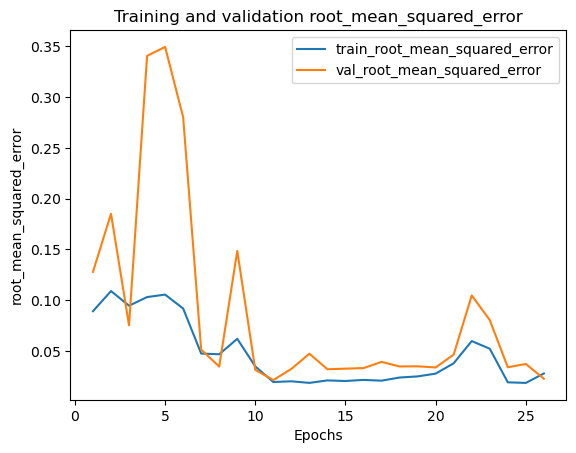

In [14]:
log = model.fit(
    xTrain,
    yTrain,
    epochs=100,
    batch_size=128, 
    validation_split = 0.25, 
    verbose=1, 
    callbacks=[earlyStopping], 
    shuffle=False)
plot_metric(log, 'root_mean_squared_error')

In [15]:
n_steps = 20

xTest = []
yTest = []

for i in range(n_steps, len(testDataScaled)):
    xTest.append(testDataScaled[i-n_steps:i, 0])
    yTest.append(testDataScaled[i, 0])
      
xTest, yTest = np.array(xTest), np.array(yTest)
xTest = np.reshape(xTest, (xTest.shape[0], xTest.shape[1], 1))  



In [16]:
predictions = model.predict(xTest) #Prediction on Data using trained model
output = sc.inverse_transform(predictions)
rmse = np.sqrt(mean_squared_error(predictions, yTest)) #Calculating of RMSE
rmse 

33/33 [==============================] - 3s 55ms/step


0.03878986984057196

In [17]:
eval = model.evaluate(xTest, yTest) #Calculating of additional metrics (Loss, RMSE, MAE)

33/33 [==============================] - 1s 42ms/step - loss: 0.0015 - root_mean_squared_error: 0.0388 - mean_absolute_error: 0.0305


The following cells are the joining of the actual data + prediction into a single DF 

In [18]:
df1 = pd.DataFrame(testingData['Adj Close']).astype(float)
df1 = df1.iloc[:-20]
df1 = df1.reset_index(drop=False)

df2 = pd.DataFrame(output, columns = ['Pred Adj Close']).astype(float)


In [19]:
df2

,Pred Adj Close
0,3275.343018
1,3271.638428
2,3266.742920
3,3262.150391
4,3259.802734
...,...
1038,4992.191406
1039,4996.060547
1040,4999.775391
1041,5004.183105


In [20]:
df = df1.join(df2)
df = df.set_index('Date')

In [21]:
df

,Adj Close,Pred Adj Close
Date,,
2020-01-02,3257.850098,3275.343018
2020-01-03,3234.850098,3271.638428
2020-01-06,3246.280029,3266.742920
2020-01-07,3237.179932,3262.150391
2020-01-08,3253.050049,3259.802734
...,...,...
2024-02-16,5005.569824,4992.191406
2024-02-20,4975.509766,4996.060547
2024-02-21,4981.799805,4999.775391


Results

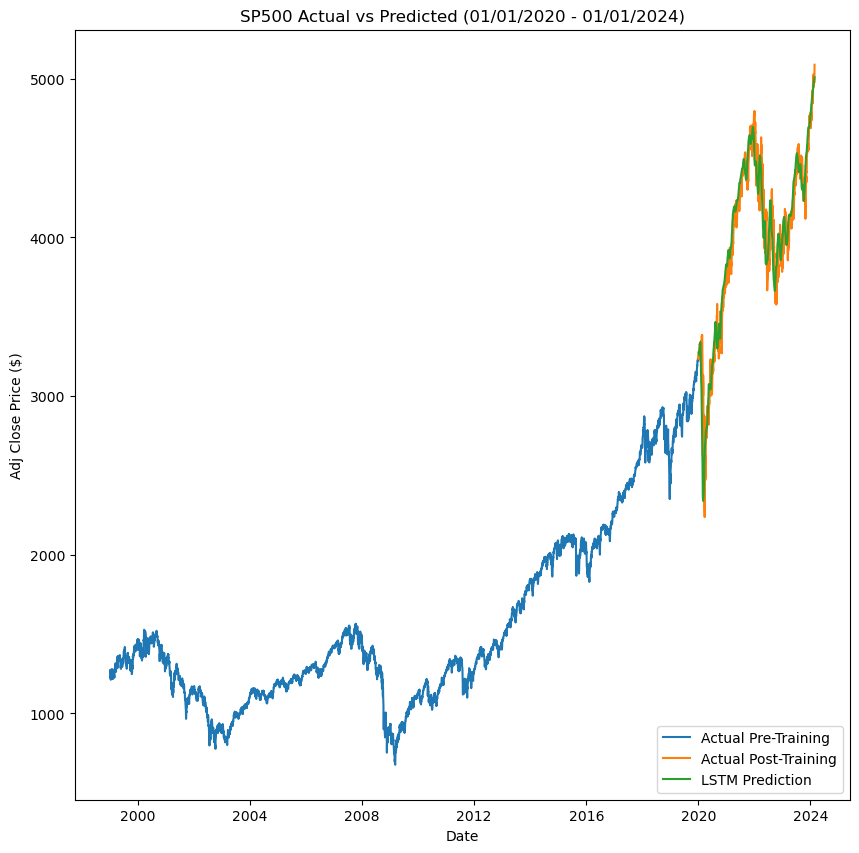

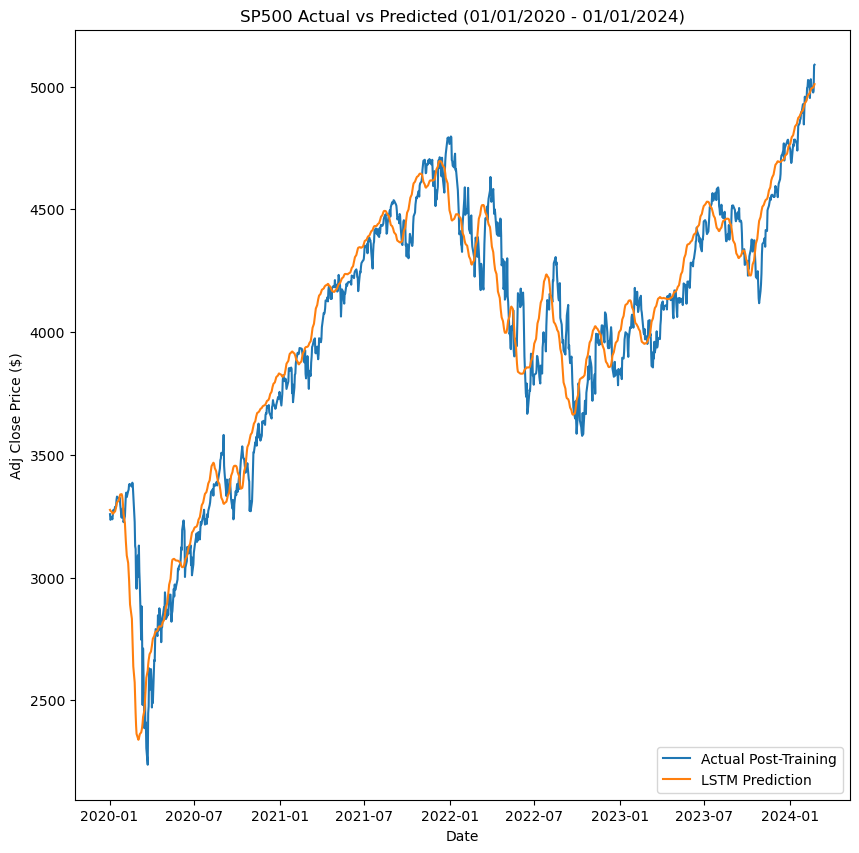

In [22]:
#plotting of graphs - Full Overview

train = trainingData['Adj Close']
real = df['Adj Close']
pred = df['Pred Adj Close']
plt.figure(figsize=(10,10))
plt.title('SP500 Actual vs Predicted (01/01/2020 - 01/01/2024)')
plt.xlabel('Date')
plt.ylabel('Adj Close Price ($)')
plt.plot(train)
plt.plot(real)
plt.plot(pred)
plt.legend(['Actual Pre-Training', 'Actual Post-Training','LSTM Prediction'], loc='lower right')
plt.xticks()
plt.show()

#plotting of graphs - Full Overview
real = df['Adj Close']
pred = df['Pred Adj Close']
plt.figure(figsize=(10,10))
plt.title('SP500 Actual vs Predicted (01/01/2020 - 01/01/2024)')
plt.xlabel('Date')
plt.ylabel('Adj Close Price ($)')
plt.plot(real)
plt.plot(pred)
plt.legend(['Actual Post-Training','LSTM Prediction'], loc='lower right')
plt.xticks()
plt.show()

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
rmse = mean_squared_error(df['Adj Close'], df['Pred Adj Close'], squared=False)

mae = mean_absolute_error(df['Adj Close'], df['Pred Adj Close'])

r2 = r2_score(df['Adj Close'], df['Pred Adj Close'])

print(f"Test RMSE : {rmse} , Test MAE {mae}, Test R2 {r2}")


Test RMSE : 150.25594498223413 , Test MAE 110.33481066110379, Test R2 0.9232143539521479


In [24]:
import plotly.express as px
import pandas as pd

# Define the data for the Gantt chart
df = pd.DataFrame([
    dict(Task="Data Finalization and Storage", Start='2024-04-01', Finish='2024-04-07', Resource='Sprint 1'),
    dict(Task="ML Algorithm Development", Start='2024-04-07', Finish='2024-04-13', Resource='Sprint 2'),
    dict(Task="UI Development and Deployment", Start='2024-04-13', Finish='2024-04-20', Resource='Sprint 3'),
    dict(Task="Testing and Deployment", Start='2024-04-20', Finish='2024-04-27', Resource='Sprint 4')
])

# Create a Gantt chart
fig = px.timeline(df, x_start="Start", x_end="Finish", y="Task", color="Resource",
                  title='Project Sprints Gantt Chart')

# Update the layout for better readability
fig.update_yaxes(autorange="reversed") 
fig.update_layout(xaxis_title='Date', yaxis_title='Task', 
                  legend_title='Sprint',
                  template='plotly_white')
fig.show()
